# Coase's Theory of the Firm -- in Julia!

**Author** [John Stachurski](https://johnstachurski.net/)

This notebooks is adapted from a [lecture using Python
code](https://python-advanced.quantecon.org/coase.html) on the
[QuantEcon](https://quantecon.org) website.

## Overview

In 1937, Ronald Coase published a brilliant essay called *The Nature of the Firm*.

Coase was writing at a time when the Soviet Union was rising to become a
significant industrial power.

At the same time, many free-market economies were afflicted by a severe and painful depression.

This contrast led to an intensive debate on the relative
merits of decentralized, price-based allocation versus top-down planning.

In the midst of this debate, Coase made an important observation:
even in free-market economies, a great deal of top-down planning does in fact take place.

This is because firms form an integral part of free-market economies and, within firms, allocation is by planning.

In other words, free-market economies blend both planning (within firms) and decentralized production coordinated by prices.

The question Coase asked is this: if prices and free markets are so efficient, then why do firms even exist?

Couldn't the associated within-firm planning be done more efficiently by the market?

We'll use the following libraries:

In [1]:
using PyPlot, QuantEcon, Interpolations,Optim, Parameters
using Optim: minimum, minimizer

### Why Firms Exist

On top of asking a deep and important question, Coase also supplied an illuminating answer: firms exist because of transaction costs.

Here's one example of a transaction cost:

Suppose agent A is considering setting up a small business and needs a web developer to construct and help run an online store.

She can use the labor of agent B, a web developer, by writing up a freelance contract for these tasks and agreeing on a suitable price.

But contracts like this can be time-consuming and difficult to verify

* How will agent A be able to specify exactly what she wants, to the finest detail, when she herself isn't sure how the business will evolve?
* And what if she isn't familiar with web technology?  How can she specify all the relevant details?
* And, if things go badly, will failure to comply with the contract be verifiable in court?

In this situation, perhaps it will be easier to *employ* agent B under a simple labor contract.

The cost of the employment contract is smaller because such contracts are simpler and more standard.

The basic agreement in a labor contract is: B will do what A asks him to do for the term of the contract, in return for a given salary.

Making this agreement is much easier than trying to map every task out in advance in a contract that will hold up in a court of law.

So agent A decides to hire agent B and a firm of nontrivial size appears, due to transaction costs.

### A Trade-Off

Actually, we haven't yet come to the heart of Coase's investigation.

The issue of why firms exist is a binary question: should firms have positive size or zero size?

A better and more general question is: **what determines the size of firms**?

The answer Coase came up with was that "a firm will tend to expand until the costs of organizing an extra
transaction within the firm become equal to the costs of carrying out the same
transaction by means of an exchange on the open market..." ({cite}`coase1937nature`, p. 395).

But what are these internal and external costs?

In short, Coase envisaged a trade-off between

* transaction costs, which add to the expense of operating *between* firms, and
* diminishing returns to management, which adds to the expense of operating *within* firms

We discussed an example of transaction costs above (contracts).

The other cost, diminishing returns to management, is a catch-all for the idea
that big operations are increasingly costly to manage.

For example, you could think of management as a pyramid, so hiring more workers to implement more tasks
requires expansion of the pyramid, and hence labor costs grow at a rate more than
proportional to the range of tasks.

Diminishing returns to management makes in-house production expensive, favoring small firms.

### Summary

Here's a summary of our discussion:

* Firms grow because transaction costs encourage them to take some operations in house.
* But as they get large, in-house operations become costly due to diminishing returns to management.
* The size of firms is determined by balancing these effects, thereby equalizing the marginal costs of each form of operation.

### A Quantitative Interpretation

Coases ideas were expressed verbally, without any mathematics.

In fact, his essay is a wonderful example of how far you can get with clear thinking and plain English.

However, plain English is not good for quantitative analysis, so let's bring some mathematical and computation tools to bear.

In doing so we'll add a bit more structure than Coase did, but this price will be worth paying.

Our exposition is based on [Kikuchi et al. 2018](https://econtheory.org/ojs/index.php/te/article/viewFile/20180729/20897/627).

## The Model

The model we study involves production of a single unit of a final good.

Production requires a linearly ordered chain, requiring sequential completion
of a large number of processing stages.

The stages are indexed by $t \in [0,1]$, with $t=0$ indicating that no tasks
have been undertaken and $t=1$ indicating that the good is complete.

### Subcontracting

The subcontracting scheme by which tasks are allocated across firms is illustrated in the figure below

![title](https://raw.githubusercontent.com/QuantEcon/lecture-python-advanced.myst/main/lectures/_static/lecture_specific/coase/subcontracting.png)

In this example,

* Firm 1 receives a contract to sell one unit of the completed good to a final buyer.
* Firm 1 then forms a contract with firm 2 to purchase the partially completed good at stage $t_1$, with
  the intention of implementing the remaining $1 - t_1$ tasks in-house (i.e., processing from stage $t_1$ to stage $1$).
* Firm 2 repeats this procedure, forming a contract with firm 3 to purchase the good at stage $t_2$.
* Firm 3 decides to complete the chain, selecting $t_3 = 0$.

At this point, production unfolds in the opposite direction (i.e., from upstream to downstream).

* Firm 3 completes processing stages from $t_3 = 0$ up to $t_2$ and transfers the good to firm 2.
* Firm 2 then processes from $t_2$ up to $t_1$ and transfers the good to firm 1,
* Firm 1 processes from $t_1$ to $1$ and delivers the completed good to the final buyer.

The length of the interval of stages (range of tasks) carried out by firm $i$ is denoted by $\ell_i$.

![title](https://raw.githubusercontent.com/QuantEcon/lecture-python-advanced.myst/main/lectures/_static/lecture_specific/coase/allocation.png)

Each firm chooses only its *upstream* boundary, treating its downstream boundary as given.

The benefit of this formulation is that it implies a recursive structure for the decision problem for each firm.

In choosing how many processing stages to subcontract, each successive firm faces essentially the same
decision problem as the firm above it in the chain, with the only difference being that the decision space is a subinterval of the decision space for the firm above.

We will exploit this recursive structure in our study of equilibrium.

### Costs

Recall that we are considering a trade-off between two types of costs.

Let's discuss these costs and how we represent them mathematically.

**Diminishing returns to management** means rising costs per task when a firm expands the range of productive activities coordinated by its managers.

We represent these ideas by taking the cost of carrying out $\ell$ tasks in-house to be $c(\ell)$, where $c$ is increasing and strictly convex.

Thus, the average cost per task rises with the range of tasks performed in-house.

We also assume that $c$ is continuously differentiable, with $c(0)=0$ and $c'(0) > 0$.

**Transaction costs** are represented as a wedge between the buyer's and seller's prices.

It matters little for us whether the transaction cost is borne by the buyer or the seller.

Here we assume that the cost is borne only by the buyer.

In particular, when two firms agree to a trade at face value $v$, the buyer's total outlay is $\delta v$, where $\delta > 1$.

The seller receives only $v$, and the difference is paid to agents outside the model.

## Equilibrium

We assume that all firms are *ex-ante* identical and act as price takers.

As price takers, they face a price function $p$, which is a map from $[0, 1]$ to $\mathbb R_+$, with $p(t)$ interpreted
as the price of the good at processing stage $t$.

There is a countable infinity of firms indexed by $i$ and no barriers to entry.

The cost of supplying the initial input (the good processed up to stage zero) is set to zero for simplicity.

Free entry and the infinite fringe of competitors rule out positive profits for incumbents,
since any incumbent could be replaced by a member of the competitive fringe
filling the same role in the production chain.

Profits are never negative in equilibrium because firms can freely exit.

### Informal Definition of Equilibrium

An equilibrium in this setting is an allocation of firms and a price function such that

1. all active firms in the chain make zero profits, including suppliers of raw materials
1. no firm in the production chain has an incentive to deviate, and
1. no inactive firms can enter and extract positive profits

### Formal Definition of Equilibrium

Let's make this definition more formal.

(You might like to skip this section on first reading)

An **allocation** of firms is a nonnegative sequence $\{\ell_i\}_{i \in \mathbb N}$ such that $\ell_i=0$ for all sufficiently large $i$.

Recalling the figures above,

* $\ell_i$ represents the range of tasks implemented by the $i$-th firm

As a labeling convention, we assume that firms enter in order, with firm 1 being the furthest downstream.

An allocation $\{\ell_i\}$ is called **feasible** if $\sum_{\, i \geq 1} \ell_i = 1$.

In a feasible allocation, the entire production process is completed by finitely many firms.

Given a feasible allocation, $\{\ell_i\}$, let $\{t_i\}$ represent the corresponding transaction stages, defined by

$$
t_0 = s \quad \text{and} \quad t_i = t_{i-1} - \ell_i
$$

In particular, $t_{i-1}$ is the downstream boundary of firm $i$ and $t_i$ is its upstream boundary.

As transaction costs are incurred only by the buyer, its profits are

$$
\pi_i = p(t_{i-1}) - c(\ell_i) - \delta p(t_i)
$$

Given a price function $p$ and a feasible allocation $\{\ell_i\}$, let

* $\{t_i\}$ be the corresponding firm boundaries.
* $\{\pi_i\}$ be corresponding profits, as defined in the previous display.

This price-allocation pair is called an **equilibrium** for the production chain if

1. $\; p(0) = 0$,
1. $\; \pi_i = 0$ for all $i$, and
1. $p(s) - c(s - t) -  \delta p(t) \leq 0$ for any pair $s, t$ with $0 \leq s \leq t \leq 1$.

The rationale behind these conditions was given in our informal definition of equilibrium above.

## Existence, Uniqueness and Computation of Equilibria

We have defined an equilibrium but does one exist?  Is it unique?  And, if so, how can we compute it?

### A Fixed Point Method

To address these questions, we introduce the operator $T$ mapping a nonnegative function $p$ on $[0, 1]$ to $Tp$ via

$$
Tp(s) = \min_{t \leq s}  \,
        \{ c(s-t) + \delta p(t) \}
       \quad \text{for all} \quad
       s \in [0,1].
$$

Here and below, the restriction $0 \leq t$ in the minimum is understood.

The operator $T$ is similar to a Bellman operator.

Under this analogy, $p$ corresponds to a value function and $\delta$ to a discount factor.

But $\delta > 1$, so $T$ is not a contraction in any obvious metric, and in fact, $T^n p$ diverges for many choices of $p$.

Nevertheless, there exists a domain on which $T$ is well-behaved:  the set
of convex increasing continuous functions $p \colon [0,1] \to \mathbb R$ such that $c'(0) s \leq p(s) \leq c(s)$ for all $0 \leq s \leq 1$.

We denote this set of functions by $\mathcal P$.

In [Kikuchi et al. 2018](https://econtheory.org/ojs/index.php/te/article/viewFile/20180729/20897/627) it is shown that the following statements are true:

1. $T$ maps $\mathcal P$ into itself.
1. $T$ has a unique fixed point in $\mathcal P$, denoted below by $p^*$.
1. For all $p \in \mathcal P$ we have $T^k p \to p^*$ uniformly as $k \to \infty$.

Now consider the choice function

$$
t^*(s) := \text{ the solution to } \min_{ t \leq s} \{c(s - t) + \delta p^*(t) \}
$$

By definition, $t^*(s)$ is the cost-minimizing upstream boundary for a firm that
is contracted to deliver the good at stage $s$ and faces the price
function $p^*$.

Since $p^*$ lies in $\mathcal P$ and since $c$ is strictly convex, it follows
that the right-hand side of the minimization problem is continuous and
strictly convex in $t$.

Hence the minimizer $t^*(s)$ exists and is uniquely defined.

We can use $t^*$ to construct an equilibrium allocation as follows:

Recall that firm 1 sells the completed good at stage $s=1$, its optimal upstream boundary is $t^*(1)$.

Hence firm 2's optimal upstream boundary is $t^*(t^*(1))$.

Continuing in this way produces the sequence $\{t^*_i\}$ defined by

$$
t_0^* = 1 \quad \text{and} \quad t_i^* = t^*(t_{i-1})
$$

The sequence ends when a firm chooses to complete all remaining tasks.

We label this firm (and hence the number of firms in the chain) as

$$
n^* := \inf \{i \in \mathbb N \,:\, t^*_i = 0\}
$$

The task allocation corresponding to this allocation is given by $\ell_i^* := t_{i-1}^* - t_i^*$ for all $i$.

In [Kikuchi et al. 2018](https://econtheory.org/ojs/index.php/te/article/viewFile/20180729/20897/627) it is shown that

1. The value $n^*$ is well-defined and finite,
1. the allocation $\{\ell^*_i\}$ is feasible, and
1. the price function $p^*$ and this allocation together forms an equilibrium for the production chain.

While the proofs are too long to repeat here,
much of the insight can be obtained by observing that, as a fixed point of $T$, the equilibrium price function must satisfy

$$
p^*(s) =
\min_{t \leq s} \, \{ c(s - t) + \delta p^*(t)  \}
\quad \text{for all} \quad s \in [0, 1]
$$

From this equation, it is clear that so profits are zero for all incumbent firms.

### Marginal Conditions

We can develop some additional insights on the behavior of firms by examining marginal conditions associated with the equilibrium.

As a first step, let $\ell^*(s) := s - t^*(s)$.

This is the cost-minimizing range of in-house tasks for a firm with downstream boundary $s$.

In [Kikuchi et al. 2018](https://econtheory.org/ojs/index.php/te/article/viewFile/20180729/20897/627)  it is shown that $t^*$ and $\ell^*$ are increasing and continuous, while $p^*$ is continuously differentiable at all $s \in (0, 1)$ with

$$
(p^*)'(s) = c'(\ell^*(s))
$$

This equation follows from $p^*(s) = \min_{t \leq s}  \, \{ c(s-t) + \delta p^*(t) \}$ and the envelope theorem for derivatives.

A related equation is the first order condition for $p^*(s) = \min_{t \leq s} \, \{ c(s-t) + \delta p^*(t) \}$, the minimization problem for a firm with upstream boundary $s$, which is

$$
\delta (p^*)'(t^*(s)) = c'(s - t^*(s))
$$

This condition matches the marginal condition expressed verbally by
Coase that we stated above:

> "A firm will tend to expand until the costs of organizing an extra
> transaction within the firm become equal to the costs of carrying
> out the same transaction by means of an exchange on the
> open market..."

Combining the last two equations and evaluating at $s=t_i$, we see that active
firms that are adjacent satisfy

$$
\delta \, c'(\ell^*_{i+1}) = c'(\ell^*_i)
$$

In other words, the marginal in-house cost per task at a given firm is equal to that of its upstream partner multiplied by gross transaction cost.

This expression can be thought of as a **Coase--Euler equation,** which determines
inter-firm efficiency by indicating how two costly forms of coordination (markets and management) are jointly minimized in equilibrium.

## Implementation

For most specifications of primitives, there is no closed-form solution for the equilibrium as far as we are aware.

However, we know that we can compute the equilibrium corresponding to a given transaction cost parameter $\delta$  and a cost function $c$
by applying the results stated above.

In particular, we can

1. fix initial condition $p \in \mathcal P$,
1. iterate with $T$ until $T^n p$ has converged to $p^*$, and
1. recover firm choices by the allocation system described above.

At each iterate, we will use continuous piecewise linear interpolation of functions.

To begin, here's a function with default values for parameters that creates a
NamedTuple to store primitives and a grid:

In [2]:
function create_production_chain(;
            n=1000,
            δ=1.05,
            θ=10.0)

        c(t) = exp(θ * t) - 1
        grid = LinRange(0, 1, n)

        return @with_kw (n=n, δ=δ, θ=θ, c=c, grid=grid)
end

create_production_chain (generic function with 1 method)

Now let's implement and iterate with $T$ until convergence.

In [3]:
function T(p, model)
    @unpack δ, c, grid = model
    Tp = similar(p)
    p_interp = LinearInterpolation(grid, p)
    for (j, s) in enumerate(grid)
        result = optimize(t -> δ * p_interp(t) + c(s - t), 0, s)
        Tp[j] = minimum(result)
    end
    return Tp
end

T (generic function with 1 method)

Recalling that our initial condition must lie in $\mathcal P$, we set
$p_0 = c$

In [4]:
"""
Compute prices by iterating with T.  The initial condition is p = c.

"""
function compute_prices(model, tol=1e-5, max_iter=5000)
    @unpack n, δ, θ, c, grid = model
    p = c.(grid)  
    error = tol + 1
    i = 0

    while (error > tol) & (i < max_iter)
        new_p = T(p, model)
        error = maximum(abs.(p - new_p))
        p = new_p
        i = i + 1
    end

    if i < max_iter
        println("Iteration converged in $i steps.")
    else
        println("Warning: iteration hit upper bound $max_iter.")
    end

    return p
end

compute_prices

The next function computes optimal choice of upstream boundary and range of
task implemented for a firm face price function p_function and with downstream boundary $s$.

In [5]:
"""
Takes p_func as the true price function, evaluated on the grid
points, and minimizes on [0,s]

Returns optimal upstream boundary t_star and optimal size of
firm ell_star

In fact, the algorithm minimizes on [-1,s] and then takes the max 
of the minimizer and zero. This yields better results close to zero.

The argument `min_firm_size` prevents generation of extremely small
firms, which leads to numerical instability.

"""
function optimal_choice(s, p, model, min_firm_size=1e-12)
    if s < min_firm_size
        t_star = 0.0
    else
        @unpack δ, c, grid = model
        p_interp = LinearInterpolation(grid, p)
        result = optimize(t -> δ * p_interp(t) + c(s - t), 0, s)
        t_star = minimizer(result)
    end
    ell_star = s - t_star
    return t_star, ell_star
end



optimal_choice

The allocation of firms can be computed by recursively stepping through firms' choices of
their respective upstream boundary, treating the previous firm's upstream boundary as their own downstream boundary.

In doing so, we start with firm 1, who has downstream boundary $s=1$.

In [6]:
function compute_stages(p, model)
    s = 1.0
    transaction_stages = [s]
    while s > 0
        s, ell = optimal_choice(s, p, model)
        push!(transaction_stages, s)
    end
    return transaction_stages
end

compute_stages (generic function with 1 method)

Let's try this at the default parameters.

The next figure shows the equilibrium price function, as well as the
boundaries of firms as vertical lines

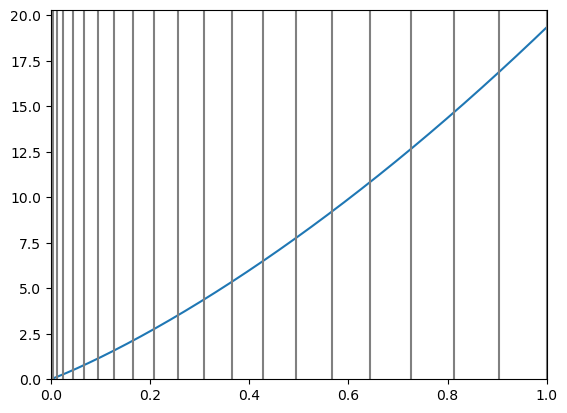

Iteration converged in 20 steps.


sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [7]:
model = create_production_chain()
@unpack grid, c = model
p = c.(grid)
p_interp = LinearInterpolation(grid, p);

p_star = compute_prices(model)


transaction_stages = compute_stages(p_star, model)

fig, ax = plt.subplots()

ax.plot(grid, p_star)
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0)
for s in transaction_stages
    ax.axvline(x=s, c="0.5")
end
plt.show();

Notice that downstream firms are larger than upstream firms (since the vertical bars are further apart near 1).

This is, in essence, because transaction costs compound as the product travels downstream.

Hence downstream firms choose to be larger, in line with Coase's prediction.

Here's the function $\ell^*$, which shows how large a firm with
downstream boundary $s$ chooses to be

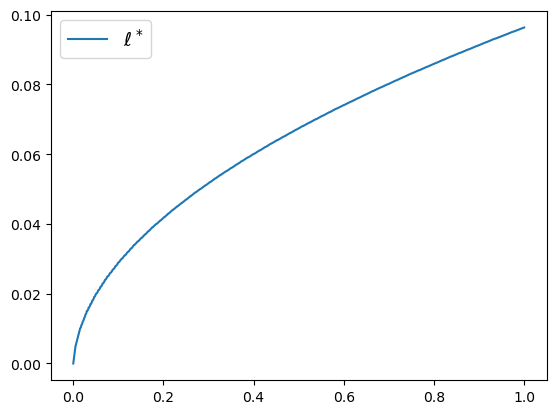

In [8]:
ell_star = []
for (i, s) in enumerate(grid)
    t, e = optimal_choice(s, p_star, model)
    push!(ell_star, e)
end

fig, ax = plt.subplots()
ax.plot(grid, ell_star, label=L"\ell^*")
ax.legend(fontsize=14)
plt.show()

Once again, we see that downstream firms choose to do more in-house than upstream firms, for reasons just discussed.